# Taller: Métodos de Runge-Kutta para la resolución de ecuaciones diferenciales ordinarias. Comparación entre rk2, rk4 y rk45.

## Introducción

En este taller se estudiarán métodos numéricos para la solución de ecuaciones diferenciales ordinarias (EDOs),
en particular los métodos de Runge-Kutta de segundo (RK2), cuarto (RK4) y quinto orden con paso adaptativo (RK45).
Se aplicarán estos métodos para resolver la ecuación de movimiento:

$$
\frac{d^2 x}{dt^2} = F_{\text{ext}}(x, t) - kx^{p-1}
$$

Se recomienda utilizar los códigos de RK4 y RK45 proporcionados, pero se deberá implementar el método RK2
para comprender su funcionamiento. Posteriormente, se analizarán las soluciones numéricas obtenidas
y se compararán con soluciones analíticas en casos específicos.

# Parte 1: Implementación del método RK2

## Objetivo
Implementar el método de Runge-Kutta de segundo orden (RK2) para resolver ecuaciones diferenciales
de la forma $\frac{d^2x}{dt^2} = f(t, x, v)$, donde $v = \frac{dx}{dt}$.

## Actividad
1. Implementar una función `rk2_step` que realice un paso del método RK2.
2. Usar `rk2_step` para resolver la ecuación de movimiento dada.
3. Graficar la posición y la velocidad en función del tiempo.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import ipywidgets as widgets
from IPython.display import display

# =============================================================================
# IMPLEMENTACIÓN DEL MÉTODO RK2
# =============================================================================
def rk2_step(f, t, y, h, *args):
    """
    Realiza un paso del método de Runge-Kutta de segundo orden (RK2).
    
    Parámetros:
    f : función
        Función que define la ecuación diferencial: dy/dt = f(t, y, *args)
    t : float
        Tiempo actual
    y : array
        Vector de estado actual [posición, velocidad]
    h : float
        Paso de tiempo
    *args : argumentos adicionales
        Parámetros adicionales para la función f
        
    Retorna:
    y_next : array
        Vector de estado en el siguiente paso de tiempo
    """
    k1 = h * f(t, y, *args)
    k2 = h * f(t + h, y + k1, *args)
    y_next = y + 0.5 * (k1 + k2)
    return y_next

# =============================================================================
# DEFINICIÓN DE LA ECUACIÓN DIFERENCIAL
# =============================================================================
def equation_of_motion(t, y, k, p, F_ext_func):
    """
    Define la ecuación de movimiento como un sistema de primer orden.
    
    Parámetros:
    t : float
        Tiempo
    y : array
        Vector de estado [posición, velocidad]
    k : float
        Constante del resorte
    p : float
        Exponente no lineal
    F_ext_func : función
        Función de fuerza externa: F_ext(t, x)
        
    Retorna:
    dydt : array
        Derivadas [velocidad, aceleración]
    """
    x, v = y
    F_ext = F_ext_func(t, x)
    acceleration = F_ext - k * x**(p-1)
    return np.array([v, acceleration])

# =============================================================================
# FUNCIÓN DE FUERZA EXTERNA (EJEMPLO)
# =============================================================================
def external_force(t, x, amplitude=0.5, frequency=0.2):
    """
    Define una fuerza externa como ejemplo.
    
    Parámetros:
    t : float
        Tiempo
    x : float
        Posición
    amplitude : float
        Amplitud de la fuerza externa
    frequency : float
        Frecuencia de la fuerza externa
        
    Retorna:
    F_ext : float
        Fuerza externa en el tiempo t y posición x
    """
    return amplitude * np.sin(2.0 * np.pi * frequency * t) #* 0

# =============================================================================
# SOLUCIÓN NUMÉRICA USANDO RK2
# =============================================================================
def solve_with_rk2(k, p, h, t_max, F_ext_func, **force_params):
    """
    Resuelve la ecuación de movimiento usando el método RK2.
    
    Parámetros:
    k : float
        Constante del resorte
    p : float
        Exponente no lineal
    h : float
        Paso de tiempo
    t_max : float
        Tiempo máximo de simulación
    F_ext_func : función
        Función de fuerza externa
    force_params : dict
        Parámetros adicionales para la función de fuerza externa
        
    Retorna:
    t_values : array
        Array de tiempos
    x_values : array
        Array de posiciones
    v_values : array
        Array de velocidades
    F_ext_values : array
        Array de fuerzas externas
    """
    # Condiciones iniciales
    y0 = np.array([1.0, 0.0])  # [posición inicial, velocidad inicial]
    
    # Número de pasos
    n_steps = int(t_max / h) + 1
    
    # Arrays para almacenar resultados
    t_values = np.linspace(0, t_max, n_steps)
    x_values = np.zeros(n_steps)
    v_values = np.zeros(n_steps)
    F_ext_values = np.zeros(n_steps)
    
    # Condición inicial
    x_values[0] = y0[0]
    v_values[0] = y0[1]
    F_ext_values[0] = F_ext_func(0, y0[0], **force_params)
    
    # Solución paso a paso
    y = y0.copy()
    for i in range(1, n_steps):
        t = t_values[i-1]
        y = rk2_step(equation_of_motion, t, y, h, k, p, 
                     lambda t, x: F_ext_func(t, x, **force_params))
        x_values[i] = y[0]
        v_values[i] = y[1]
        F_ext_values[i] = F_ext_func(t_values[i], y[0], **force_params)
    
    return t_values, x_values, v_values, F_ext_values

# =============================================================================
# FUNCIÓN DE VISUALIZACIÓN INTERACTIVA
# =============================================================================
def interactive_plot(k=1.0, p=2, h=0.1, t_max=20.0, 
                    amplitude=0.5, frequency=0.2, damping=0.0):
    """
    Función interactiva para visualizar la solución de la ecuación diferencial.
    
    Parámetros:
    k : float
        Constante del resorte
    p : int
        Exponente no lineal (debe ser entero para el slider)
    h : float
        Paso de tiempo
    t_max : float
        Tiempo máximo de simulación
    amplitude : float
        Amplitud de la fuerza externa
    frequency : float
        Frecuencia de la fuerza externa
    damping : float
        Coeficiente de amortiguamiento (no implementado en este ejemplo)
    """
    # Convertir p a float para el cálculo
    p_float = float(p)
    
    # Resolver la ecuación
    t, x, v, F_ext = solve_with_rk2(
        k, p_float, h, t_max, external_force, 
        amplitude=amplitude, frequency=frequency
    )
    
    # Crear figura con subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Solución de la Ecuación Diferencial con RK2\n(k={k}, p={p}, h={h})', fontsize=14)
    
    # Gráfica de posición vs tiempo
    ax1.plot(t, x, 'b-', linewidth=2)
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('Posición')
    ax1.set_title('Posición vs Tiempo')
    ax1.grid(True)
    
    # Gráfica de velocidad vs tiempo
    ax2.plot(t, v, 'r-', linewidth=2)
    ax2.set_xlabel('Tiempo')
    ax2.set_ylabel('Velocidad')
    ax2.set_title('Velocidad vs Tiempo')
    ax2.grid(True)
    
    # Gráfica de fuerza externa vs tiempo
    ax3.plot(t, F_ext, 'g-', linewidth=2)
    ax3.set_xlabel('Tiempo')
    ax3.set_ylabel('Fuerza Externa')
    ax3.set_title('Fuerza Externa vs Tiempo')
    ax3.grid(True)
    
    # Gráfica de espacio de fase (posición vs velocidad)
    ax4.plot(x, v, 'm-', linewidth=2)
    ax4.set_xlabel('Posición')
    ax4.set_ylabel('Velocidad')
    ax4.set_title('Espacio de Fase')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# CREACIÓN DE SLIDERS INTERACTIVOS
# =============================================================================
# Definir los sliders con ipywidgets
k_slider = FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='k:')
p_slider = IntSlider(value=2, min=1, max=10, step=1, description='p:')
h_slider = FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Paso:')
t_max_slider = FloatSlider(value=20.0, min=5.0, max=50.0, step=1.0, description='Tiempo máx:')
amplitude_slider = FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1, description='Amplitud:')
frequency_slider = FloatSlider(value=0.2, min=0.05, max=1.0, step=0.05, description='Frecuencia:')
damping_slider = FloatSlider(value=0.0, min=0.0, max=0.5, step=0.01, description='Amortiguamiento:')

# =============================================================================
# INTERFAZ INTERACTIVA
# =============================================================================
# Crear la interfaz interactiva
ui = widgets.VBox([
    widgets.HBox([k_slider, p_slider]),
    widgets.HBox([h_slider, t_max_slider]),
    widgets.HBox([amplitude_slider, frequency_slider]),
    damping_slider
])

# Conectar la función de visualización con los sliders
out = widgets.interactive_output(interactive_plot, {
    'k': k_slider,
    'p': p_slider,
    'h': h_slider,
    't_max': t_max_slider,
    'amplitude': amplitude_slider,
    'frequency': frequency_slider,
    'damping': damping_slider
})

# Mostrar la interfaz
display(ui, out)

Output()

# Parte 2: Validación del método RK2 con un oscilador armónico

## Objetivo
Comprobar el correcto funcionamiento del método RK2 resolviendo la ecuación de un oscilador armónico
y comparando con la solución analítica.

$$ x(t) = A \sin(\omega_0 t), \quad v(t) = \omega_0 A \cos(\omega_0 t), \quad \omega_0 = \sqrt{k/m} $$

## Actividad
1. Ajustar los parámetros para que el sistema sea un oscilador armónico puro.
2. Resolver la ecuación con RK2 y comparar con la solución analítica.
3. Analizar el efecto del tamaño de paso \(h\).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# =============================================================================
# IMPLEMENTACIÓN DEL MÉTODO RK2 PARA OSCILADOR ARMÓNICO
# =============================================================================
def rk2_step_oscillator(t, x, v, h, omega_sq):
    """
    Realiza un paso del método RK2 para el oscilador armónico.
    
    Parámetros:
    t : float
        Tiempo actual
    x : float
        Posición actual
    v : float
        Velocidad actual
    h : float
        Paso de tiempo
    omega_sq : float
        Cuadrado de la frecuencia angular (ω² = k/m)
        
    Retorna:
    x_next : float
        Posición en el siguiente paso
    v_next : float
        Velocidad en el siguiente paso
    """
    # Primeras evaluaciones (k1 para x y v)
    k1_x = h * v
    k1_v = h * (-omega_sq * x)
    
    # Evaluaciones en el punto medio (k2 para x y v)
    k2_x = h * (v + 0.5 * k1_v)
    k2_v = h * (-omega_sq * (x + 0.5 * k1_x))
    
    # Siguiente paso
    x_next = x + k2_x
    v_next = v + k2_v
    
    return x_next, v_next

# =============================================================================
# SOLUCIÓN ANALÍTICA DEL OSCILADOR ARMÓNICO
# =============================================================================
def analytical_solution(t, A, omega):
    """
    Calcula la solución analítica del oscilador armónico.
    
    Parámetros:
    t : array
        Tiempos donde evaluar la solución
    A : float
        Amplitud
    omega : float
        Frecuencia angular (ω = √(k/m))
        
    Retorna:
    x_analytical : array
        Posiciones analíticas
    v_analytical : array
        Velocidades analíticas
    """
    x_analytical = A * np.sin(omega * t)
    v_analytical = A * omega * np.cos(omega * t)
    return x_analytical, v_analytical

# =============================================================================
# SOLUCIÓN NUMÉRICA USANDO RK2
# =============================================================================
def solve_oscillator_rk2(A, k, m, h, t_max):
    """
    Resuelve la ecuación del oscilador armónico usando RK2.
    
    Parámetros:
    A : float
        Amplitud inicial
    k : float
        Constante del resorte
    m : float
        Masa
    h : float
        Paso de tiempo
    t_max : float
        Tiempo máximo de simulación
        
    Retorna:
    t_values : array
        Array de tiempos
    x_values : array
        Array de posiciones numéricas
    v_values : array
        Array de velocidades numéricas
    x_analytical : array
        Array de posiciones analíticas
    v_analytical : array
        Array de velocidades analíticas
    """
    # Parámetros derivados
    omega = np.sqrt(k / m)  # Frecuencia angular
    omega_sq = k / m        # Cuadrado de la frecuencia angular
    
    # Condiciones iniciales
    x0 = 0.0      # Comenzamos en posición cero
    v0 = A * omega  # Velocidad inicial para tener amplitud A
    
    # Número de pasos
    n_steps = int(t_max / h) + 1
    
    # Arrays para almacenar resultados
    t_values = np.linspace(0, t_max, n_steps)
    x_values = np.zeros(n_steps)
    v_values = np.zeros(n_steps)
    
    # Condición inicial
    x_values[0] = x0
    v_values[0] = v0
    
    # Solución paso a paso con RK2
    x, v = x0, v0
    for i in range(1, n_steps):
        x, v = rk2_step_oscillator(t_values[i-1], x, v, h, omega_sq)
        x_values[i] = x
        v_values[i] = v
    
    # Solución analítica
    x_analytical, v_analytical = analytical_solution(t_values, A, omega)
    
    return t_values, x_values, v_values, x_analytical, v_analytical

# =============================================================================
# FUNCIÓN DE VISUALIZACIÓN INTERACTIVA
# =============================================================================
def plot_oscillator_comparison(A=1.0, k=1.0, m=1.0, h=0.1, t_max=20.0):
    """
    Función interactiva para comparar solución numérica y analítica.
    
    Parámetros:
    A : float
        Amplitud
    k : float
        Constante del resorte
    m : float
        Masa
    h : float
        Paso de tiempo
    t_max : float
        Tiempo máximo de simulación
    """
    # Resolver numéricamente y obtener solución analítica
    t, x_num, v_num, x_ana, v_ana = solve_oscillator_rk2(A, k, m, h, t_max)
    
    # Calcular error
    error_x = np.abs(x_num - x_ana)
    error_v = np.abs(v_num - v_ana)
    
    # Crear figura con subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Gráfica de posición
    ax1.plot(t, x_num, 'b-', linewidth=2, label='RK2')
    ax1.plot(t, x_ana, 'r--', linewidth=1.5, label='Analítica')
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('Posición')
    ax1.set_title('Posición vs Tiempo')
    ax1.legend()
    ax1.grid(True)
    
    # Gráfica de velocidad
    ax2.plot(t, v_num, 'b-', linewidth=2, label='RK2')
    ax2.plot(t, v_ana, 'r--', linewidth=1.5, label='Analítica')
    ax2.set_xlabel('Tiempo')
    ax2.set_ylabel('Velocidad')
    ax2.set_title('Velocidad vs Tiempo')
    ax2.legend()
    ax2.grid(True)
    
    # Gráfica de error en posición
    ax3.plot(t, error_x, 'g-', linewidth=2)
    ax3.set_xlabel('Tiempo')
    ax3.set_ylabel('Error absoluto')
    ax3.set_title('Error en Posición')
    ax3.grid(True)
    ax3.set_yscale('log')  # Escala logarítmica para mejor visualización del error
    
    # Gráfica de espacio de fase
    ax4.plot(x_num, v_num, 'b-', linewidth=2, label='RK2')
    ax4.plot(x_ana, v_ana, 'r--', linewidth=1.5, label='Analítica')
    ax4.set_xlabel('Posición')
    ax4.set_ylabel('Velocidad')
    ax4.set_title('Espacio de Fase')
    ax4.legend()
    ax4.grid(True)
    
    # Añadir información sobre el error máximo
    max_error_x = np.max(error_x)
    max_error_v = np.max(error_v)
    
    # Añadir texto con información
    plt.figtext(0.5, 0.01, 
                f'Error máximo en posición: {max_error_x:.2e} | '
                f'Error máximo en velocidad: {max_error_v:.2e} | '
                f'Paso h: {h} | '
                f'Período T: {2*np.pi*np.sqrt(m/k):.2f}',
                ha='center', fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

# =============================================================================
# ANÁLISIS DE CONVERGENCIA CON DIFERENTES TAMAÑOS DE PASO
# =============================================================================
def convergence_analysis(A=1.0, k=1.0, m=1.0, t_max=10.0):
    """
    Analiza la convergencia del método RK2 para diferentes tamaños de paso.
    
    Parámetros:
    A : float
        Amplitud
    k : float
        Constante del resorte
    m : float
        Masa
    t_max : float
        Tiempo máximo de simulación
    """
    # Diferentes tamaños de paso a probar
    h_values = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
    errors = []
    
    omega = np.sqrt(k / m)
    
    for h in h_values:
        # Resolver numéricamente
        t, x_num, v_num, x_ana, v_ana = solve_oscillator_rk2(A, k, m, h, t_max)
        
        # Calcular error máximo
        error_x = np.max(np.abs(x_num - x_ana))
        errors.append(error_x)
    
    # Graficar error vs tamaño de paso
    plt.figure(figsize=(10, 6))
    plt.loglog(h_values, errors, 'o-', linewidth=2, markersize=8, label='Error máximo')
    
    # Añadir línea de referencia para convergencia de segundo orden (h²)
    h_ref = np.array(h_values)
    ref_error = 0.1 * h_ref**2  # Escalado arbitrario para visualización
    plt.loglog(h_ref, ref_error, 'r--', linewidth=2, label='Referencia O(h²)')
    
    plt.xlabel('Tamaño de paso (h)')
    plt.ylabel('Error máximo en posición')
    plt.title('Análisis de Convergencia del Método RK2')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    
    # Añadir información adicional
    plt.figtext(0.5, 0.01, 
                f'El método RK2 muestra convergencia de segundo orden: el error disminuye como h²',
                ha='center', fontsize=12, bbox={"facecolor":"lightblue", "alpha":0.2, "pad":5})
    
    plt.show()

# =============================================================================
# INTERFAZ INTERACTIVA
# =============================================================================
# Crear sliders
A_slider = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Amplitud (A):')
k_slider = FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Constante (k):')
m_slider = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Masa (m):')
h_slider = FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Paso (h):')
t_max_slider = FloatSlider(value=20.0, min=5.0, max=50.0, step=1.0, description='Tiempo máx:')

# Organizar la interfaz
ui = widgets.VBox([
    widgets.HBox([A_slider, k_slider]),
    widgets.HBox([m_slider, h_slider]),
    t_max_slider
])

# Crear pestañas para diferentes análisis
tab = widgets.Tab()
tab.children = [
    widgets.interactive_output(plot_oscillator_comparison, {
        'A': A_slider, 'k': k_slider, 'm': m_slider, 'h': h_slider, 't_max': t_max_slider
    }),
    widgets.interactive_output(convergence_analysis, {
        'A': A_slider, 'k': k_slider, 'm': m_slider, 't_max': t_max_slider
    })
]
tab.titles = ['Comparación Soluciones', 'Análisis de Convergencia']

# Mostrar la interfaz
display(ui, tab)

# Parte 3: Comparación de RK2 con RK4 y RK45

## Objetivo
Comparar la precisión de los métodos RK2, RK4 y RK45 resolviendo la ecuación de movimiento.

## Actividad
1. Utilizar los códigos de RK4 y RK45 proporcionados para resolver la ecuación.
2. Comparar los resultados numéricos con una solución analítica o con una referencia.
3. Analizar la eficiencia de cada método en términos de error y número de pasos.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
import time

# =============================================================================
# IMPLEMENTACIÓN DE RK2
# =============================================================================
def rk2_step(f, t, y, h, *args):
    """
    Realiza un paso del método de Runge-Kutta de segundo orden (RK2).
    """
    k1 = h * f(t, y, *args)
    k2 = h * f(t + h, y + k1, *args)
    return y + 0.5 * (k1 + k2)

# =============================================================================
# IMPLEMENTACIÓN DE RK4
# =============================================================================
def rk4_step(f, t, y, h, *args):
    """
    Realiza un paso del método de Runge-Kutta de cuarto orden (RK4).
    """
    k1 = h * f(t, y, *args)
    k2 = h * f(t + h/2, y + k1/2, *args)
    k3 = h * f(t + h/2, y + k2/2, *args)
    k4 = h * f(t + h, y + k3, *args)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

# =============================================================================
# IMPLEMENTACIÓN DE RK45 (ADAPTATIVO)
# =============================================================================
def rk45_step(f, t, y, h, tol, *args):
    """
    Realiza un paso adaptativo del método de Runge-Kutta-Fehlberg (RK45).
    """
    # Coeficientes de Butcher para RK4(5)
    k1 = h * f(t, y, *args)
    k2 = h * f(t + h/4, y + k1/4, *args)
    k3 = h * f(t + 3*h/8, y + 3*k1/32 + 9*k2/32, *args)
    k4 = h * f(t + 12*h/13, y + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197, *args)
    k5 = h * f(t + h, y + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104, *args)
    k6 = h * f(t + h/2, y - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40, *args)
    
    # Solución de cuarto y quinto orden
    y4 = y + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5  # RK4
    y5 = y + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55  # RK5
    
    # Estimación del error
    error = np.max(np.abs(y5 - y4))
    
    # Factor de ajuste del paso
    if error == 0:
        s = 2.0  # Máxima amplificación si no hay error
    else:
        s = 0.84 * (tol * h / error)**0.25
    
    # Ajustar el paso
    if error < tol:
        # Paso aceptado
        return y5, True, min(2*h, h*10)  # Limitar la amplificación máxima
    else:
        # Paso rechazado, reducir tamaño
        return y, False, max(h * max(0.1, s), h*0.1)  # Limitar la reducción mínima

# =============================================================================
# DEFINICIÓN DE LA ECUACIÓN DIFERENCIAL (OSCILADOR ARMÓNICO)
# =============================================================================
def harmonic_oscillator(t, y, k, m):
    """
    Ecuación del oscilador armónico: d²x/dt² = - (k/m) * x
    Convertida a sistema de primer orden:
    y[0] = x (posición)
    y[1] = v (velocidad)
    dy[0]/dt = v
    dy[1]/dt = - (k/m) * x
    """
    x, v = y
    return np.array([v, - (k/m) * x])

# =============================================================================
# SOLUCIÓN ANALÍTICA DEL OSCILADOR ARMÓNICO
# =============================================================================
def analytical_solution(t, A, omega):
    """
    Solución analítica del oscilador armónico.
    x(t) = A * sin(ωt)
    v(t) = A * ω * cos(ωt)
    """
    x_analytical = A * np.sin(omega * t)
    v_analytical = A * omega * np.cos(omega * t)
    return x_analytical, v_analytical

# =============================================================================
# RESOLVER CON DIFERENTES MÉTODOS
# =============================================================================
def solve_ode(method, f, t_range, y0, h, tol, *args):
    """
    Resuelve la EDO usando el método especificado.
    """
    t_start, t_end = t_range
    t = t_start
    y = y0.copy()
    
    # Inicializar arrays para almacenar resultados
    t_values = [t]
    y_values = [y.copy()]
    n_steps = 0
    
    # Medir tiempo de computación
    start_time = time.time()
    
    if method == rk45_step:
        # RK45 adaptativo
        h_current = h
        while t < t_end:
            if t + h_current > t_end:
                h_current = t_end - t
                
            y_new, accepted, h_new = method(f, t, y, h_current, tol, *args)
            
            if accepted:
                t += h_current
                y = y_new
                t_values.append(t)
                y_values.append(y.copy())
            
            h_current = h_new
            n_steps += 1
            
    else:
        # RK2 o RK4 con paso fijo
        while t < t_end:
            if t + h > t_end:
                h_step = t_end - t
            else:
                h_step = h
                
            y = method(f, t, y, h_step, *args)
            t += h_step
            t_values.append(t)
            y_values.append(y.copy())
            n_steps += 1
    
    computation_time = time.time() - start_time
    
    return np.array(t_values), np.array(y_values), n_steps, computation_time

# =============================================================================
# COMPARACIÓN DE MÉTODOS
# =============================================================================
def compare_methods(A=1.0, k=1.0, m=1.0, h=0.1, t_max=10.0, tol=1e-6):
    """
    Compara los métodos RK2, RK4 y RK45.
    """
    # Parámetros
    omega = np.sqrt(k / m)  # Frecuencia angular
    y0 = np.array([0.0, A * omega])  # Condición inicial [x0, v0]
    
    # Resolver con cada método
    methods = {
        'RK2': rk2_step,
        'RK4': rk4_step,
        'RK45': rk45_step
    }
    
    results = {}
    
    for name, method in methods.items():
        if name == 'RK45':
            t, y, n_steps, comp_time = solve_ode(
                method, harmonic_oscillator, (0, t_max), y0, h, tol, k, m
            )
        else:
            t, y, n_steps, comp_time = solve_ode(
                method, harmonic_oscillator, (0, t_max), y0, h, tol, k, m
            )
        
        results[name] = {
            't': t,
            'x': y[:, 0],
            'v': y[:, 1],
            'n_steps': n_steps,
            'comp_time': comp_time
        }
    
    # Solución analítica (evaluada en los puntos de tiempo de RK2 como referencia)
    x_ana, v_ana = analytical_solution(results['RK2']['t'], A, omega)
    
    # Calcular errores
    for name in results:
        x_num = results[name]['x']
        v_num = results[name]['v']
        t_num = results[name]['t']
        
        # Calcular solución analítica en los puntos de tiempo de este método
        x_ana_method, v_ana_method = analytical_solution(t_num, A, omega)
        
        error_x = np.abs(x_num - x_ana_method)
        error_v = np.abs(v_num - v_ana_method)
        
        results[name]['error_x'] = error_x
        results[name]['error_v'] = error_v
        results[name]['max_error'] = np.max(error_x)
        results[name]['avg_error'] = np.mean(error_x)
    
    return results, x_ana, v_ana

# =============================================================================
# VISUALIZACIÓN DE RESULTADOS (CORREGIDA)
# =============================================================================
def plot_comparison(A=1.0, k=1.0, m=1.0, h=0.1, t_max=10.0, tol=1e-6):
    """
    Grafica la comparación de los métodos RK2, RK4 y RK45.
    """
    # Comparar métodos
    results, x_ana, v_ana = compare_methods(A, k, m, h, t_max, tol)
    t_ref = results['RK2']['t']
    
    # Crear figura
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Colores para cada método
    colors = {'RK2': 'blue', 'RK4': 'green', 'RK45': 'red'}
    
    # Gráfica de posición
    axes[0, 0].plot(t_ref, x_ana, 'k--', linewidth=2, label='Analítica')
    for name, data in results.items():
        axes[0, 0].plot(data['t'], data['x'], color=colors[name], linewidth=1.5, label=name)
    axes[0, 0].set_xlabel('Tiempo')
    axes[0, 0].set_ylabel('Posición')
    axes[0, 0].set_title('Comparación de Posición')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Gráfica de error en posición
    for name, data in results.items():
        # Para RK45, usar sus propios puntos temporales
        axes[0, 1].semilogy(data['t'], data['error_x'], color=colors[name], linewidth=1.5, label=name)
    axes[0, 1].set_xlabel('Tiempo')
    axes[0, 1].set_ylabel('Error (log)')
    axes[0, 1].set_title('Error en Posición')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Gráfica de espacio de fase
    axes[0, 2].plot(x_ana, v_ana, 'k--', linewidth=2, label='Analítica', alpha=0.5)
    for name, data in results.items():
        axes[0, 2].plot(data['x'], data['v'], color=colors[name], linewidth=1.5, label=name)
    axes[0, 2].set_xlabel('Posición')
    axes[0, 2].set_ylabel('Velocidad')
    axes[0, 2].set_title('Espacio de Fase')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # Tabla de comparación
    methods = ['RK2', 'RK4', 'RK45']
    n_steps = [results[name]['n_steps'] for name in methods]
    comp_times = [results[name]['comp_time'] for name in methods]
    max_errors = [results[name]['max_error'] for name in methods]
    avg_errors = [results[name]['avg_error'] for name in methods]
    
    # Gráfica de barras: número de pasos
    axes[1, 0].bar(methods, n_steps, color=[colors[name] for name in methods])
    axes[1, 0].set_xlabel('Método')
    axes[1, 0].set_ylabel('Número de pasos')
    axes[1, 0].set_title('Número de Pasos')
    for i, v in enumerate(n_steps):
        axes[1, 0].text(i, v, str(v), ha='center', va='bottom')
    
    # Gráfica de barras: tiempo de computación
    axes[1, 1].bar(methods, comp_times, color=[colors[name] for name in methods])
    axes[1, 1].set_xlabel('Método')
    axes[1, 1].set_ylabel('Tiempo (s)')
    axes[1, 1].set_title('Tiempo de Computación')
    for i, v in enumerate(comp_times):
        axes[1, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom')
    
    # Gráfica de barras: error máximo
    axes[1, 2].bar(methods, max_errors, color=[colors[name] for name in methods])
    axes[1, 2].set_xlabel('Método')
    axes[1, 2].set_ylabel('Error máximo')
    axes[1, 2].set_title('Error Máximo')
    axes[1, 2].set_yscale('log')
    for i, v in enumerate(max_errors):
        axes[1, 2].text(i, v, f'{v:.2e}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Información adicional
    plt.figtext(0.5, 0.01, 
                f'Parámetros: A={A}, k={k}, m={m}, h={h}, t_max={t_max}, tol={tol} | '
                f'Frecuencia ω={np.sqrt(k/m):.2f}, Período T={2*np.pi*np.sqrt(m/k):.2f}',
                ha='center', fontsize=10, bbox={"facecolor":"lightgray", "alpha":0.3, "pad":5})
    
    plt.show()

# =============================================================================
# INTERFAZ INTERACTIVA
# =============================================================================
# Crear sliders
A_slider = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Amplitud (A):')
k_slider = FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Constante (k):')
m_slider = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Masa (m):')
h_slider = FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Paso (h):')
t_max_slider = FloatSlider(value=10.0, min=1.0, max=50.0, step=1.0, description='Tiempo máx:')
tol_slider = FloatSlider(value=1e-6, min=1e-8, max=1e-3, step=1e-7, description='Tolerancia:', readout_format='.1e')

# Organizar la interfaz
ui = widgets.VBox([
    widgets.HBox([A_slider, k_slider]),
    widgets.HBox([m_slider, h_slider]),
    widgets.HBox([t_max_slider, tol_slider])
])

# Crear la interfaz interactiva
out = widgets.interactive_output(plot_comparison, {
    'A': A_slider,
    'k': k_slider,
    'm': m_slider,
    'h': h_slider,
    't_max': t_max_slider,
    'tol': tol_slider
})

# Mostrar la interfaz
display(ui, out)

Output()

# Parte 4: Comparación cuantitativa de RK4 y RK45

## Objetivo
Evaluar el rendimiento de los métodos RK4 y RK45 con diferentes ecuaciones.

## Actividad
1. Resolver las ecuaciones:

$$ 2yy′′+ y^2− y′^2= 0 $$

$$ y′′+ 6y^5= 0 $$

con condiciones iniciales $y(0) = 1$, $y′(0) = 1$.

2. Comparar la precisión de RK4 y RK45.
3. Construir una tabla con los resultados.

Fijese que una de las dos EDOs no es lineal y tiene una solución analitica $y(t)=1+\sin(t)$ y la otra corresponde a un potencial estándar con $p=6$.

4. Muestre que si se fija su parámetro de tolerancia a un número suficientemente pequeño rk45 obtendrá mejor precisión que rk4 (grafique Error vs tiempo de ejecución), pero que requiere $\approx 10$ veces más operaciones en coma flotante y tarda $\approx 5$ veces más.

In [8]:
# RK4 vs RK45 comparison for two second-order ODEs
# 1) 2*y*y'' + (y')^2 - y^2 = 0
# 2) y'' + 6*y**5 = 0
#
# We convert each to first-order system: y1 = y, y2 = y'
# y1' = y2
# y2' = ...  (derived from equation)
#
# We'll:
# - Implement RK4 integrator (fixed step)
# - Use scipy.solve_ivp(method='RK45') as adaptive reference / solver
# - Compare final values for several dt and build a table of errors vs a high-accuracy reference
# - Print a pandas table with results
#
# Notes:
# - If scipy is not installed in the environment, this cell will attempt to install it.
# - We use a highly accurate solve_ivp (DOP853) as reference to avoid relying on an unavailable analytic solution.
# - Initial conditions: y(0)=1, y'(0)=1 as requested.
#

import sys, subprocess, math, importlib

# Ensure required packages are installed: scipy, pandas
def ensure_pkg(pkg):
    try:
        importlib.import_module(pkg)
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        print(f"{pkg} installed.")

for p in ("scipy", "pandas"):
    ensure_pkg(p)

import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Define the two ODE systems
# -----------------------------
def rhs1(t, y):
    # Equation: 2*y*y'' + (y')^2 - y^2 = 0
    # Solve for y'': y'' = (y^2 - (y')^2) / (2*y)  provided y != 0
    y1, y2 = y
    if abs(y1) < 1e-14:
        # avoid division by zero; use limit approx
        ypp = 0.0
    else:
        ypp = (y1**2 - y2**2) / (2.0 * y1)
    return [y2, ypp]

def rhs2(t, y):
    # Equation: y'' + 6*y^5 = 0  -> y'' = -6*y^5
    y1, y2 = y
    return [y2, -6.0 * y1**5]

# Initial conditions
y0 = [1.0, 1.0]
t0 = 0.0
tf = 5.0

# -----------------------------
# RK4 fixed-step integrator
# -----------------------------
def rk4_integrate(fun, t0, y0, tf, dt):
    t_vals = np.arange(t0, tf + 1e-12, dt)
    n = len(t_vals)
    y_vals = np.zeros((n, len(y0)))
    y = np.array(y0, dtype=float)
    y_vals[0] = y
    for i in range(n-1):
        t = t_vals[i]
        h = t_vals[i+1] - t_vals[i]
        k1 = np.array(fun(t, y))
        k2 = np.array(fun(t + 0.5*h, y + 0.5*h*k1))
        k3 = np.array(fun(t + 0.5*h, y + 0.5*h*k2))
        k4 = np.array(fun(t + h, y + h*k3))
        y = y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        y_vals[i+1] = y
    return t_vals, y_vals

# -----------------------------
# High-accuracy reference using DOP853 (or RK45 with tight tol)
# -----------------------------
def reference_solution(fun, t0, y0, tf):
    sol = solve_ivp(fun, (t0, tf), y0, method='DOP853', rtol=1e-12, atol=1e-14, dense_output=True)
    ts = np.linspace(t0, tf, 2001)
    ys = sol.sol(ts).T
    return ts, ys, sol

# -----------------------------
# Run reference for both systems
# -----------------------------
ts1_ref, ys1_ref, sol1 = reference_solution(rhs1, t0, y0, tf)
ts2_ref, ys2_ref, sol2 = reference_solution(rhs2, t0, y0, tf)

# We'll use the reference sol at final time as "truth" for error comparisons
y1_ref_final = ys1_ref[-1]
y2_ref_final = ys2_ref[-1]

# -----------------------------
# Compare RK4 with several dt and RK45 (solve_ivp) with default tolerance
# -----------------------------
dt_values = [0.5, 0.25, 0.1, 0.05, 0.01]
results = []

for dt in dt_values:
    # RK4 for system 1
    t_rk4_1, y_rk4_1 = rk4_integrate(rhs1, t0, y0, tf, dt)
    y_rk4_1_final = y_rk4_1[-1]

    # RK4 for system 2
    t_rk4_2, y_rk4_2 = rk4_integrate(rhs2, t0, y0, tf, dt)
    y_rk4_2_final = y_rk4_2[-1]

    # RK45 via solve_ivp for comparison (default rtol)
    sol_rk45_1 = solve_ivp(rhs1, (t0, tf), y0, method='RK45', rtol=1e-6, atol=1e-9)
    y_rk45_1_final = sol_rk45_1.y[:, -1]

    sol_rk45_2 = solve_ivp(rhs2, (t0, tf), y0, method='RK45', rtol=1e-6, atol=1e-9)
    y_rk45_2_final = sol_rk45_2.y[:, -1]

    # Errors vs reference (use norm of vector [y,y'])
    err_rk4_1 = np.linalg.norm(y_rk4_1_final - y1_ref_final, ord=2)
    err_rk45_1 = np.linalg.norm(y_rk45_1_final - y1_ref_final, ord=2)

    err_rk4_2 = np.linalg.norm(y_rk4_2_final - y2_ref_final, ord=2)
    err_rk45_2 = np.linalg.norm(y_rk45_2_final - y2_ref_final, ord=2)

    results.append({
        "dt": dt,
        "RK4_y_final_sys1": y_rk4_1_final[0],
        "RK4_yprime_final_sys1": y_rk4_1_final[1],
        "RK4_err_sys1": err_rk4_1,
        "RK45_y_final_sys1": y_rk45_1_final[0],
        "RK45_err_sys1": err_rk45_1,
        "RK4_y_final_sys2": y_rk4_2_final[0],
        "RK4_yprime_final_sys2": y_rk4_2_final[1],
        "RK4_err_sys2": err_rk4_2,
        "RK45_y_final_sys2": y_rk45_2_final[0],
        "RK45_err_sys2": err_rk45_2,
    })

# Build DataFrame
df = pd.DataFrame(results)
df = df[["dt",
         "RK4_y_final_sys1", "RK4_yprime_final_sys1", "RK4_err_sys1", "RK45_y_final_sys1", "RK45_err_sys1",
         "RK4_y_final_sys2", "RK4_yprime_final_sys2", "RK4_err_sys2", "RK45_y_final_sys2", "RK45_err_sys2"
        ]]
pd.set_option("display.precision", 6)
df

/tmp/ipykernel_82334/409274501.py:57: RuntimeWarning: overflow encountered in scalar power
  return [y2, -6.0 * y1**5]
/tmp/ipykernel_82334/409274501.py:80: RuntimeWarning: invalid value encountered in add
  y = y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)


,dt,RK4_y_final_sys1,RK4_yprime_final_sys1,RK4_err_sys1,RK45_y_final_sys1,RK45_err_sys1,RK4_y_final_sys2,RK4_yprime_final_sys2,RK4_err_sys2,RK45_y_final_sys2,RK45_err_sys2
0,0.50,22.073596,12.745392,7.008081e-03,22.07968,0.000011,NaN,NaN,NaN,-0.661133,7.000036e-07
1,0.25,22.079264,12.748654,4.693121e-04,22.07968,0.000011,-0.951969,0.958397,7.809278e-01,-0.661133,7.000036e-07
2,0.10,22.079660,12.748882,1.230511e-05,22.07968,0.000011,-0.669406,1.675360,1.136200e-02,-0.661133,7.000036e-07
3,0.05,22.079670,12.748887,7.723300e-07,22.07968,0.000011,-0.661516,1.682831,4.965854e-04,-0.661133,7.000036e-07
4,0.01,22.079670,12.748888,1.234716e-09,22.07968,0.000011,-0.661133,1.683146,4.735185e-07,-0.661133,7.000036e-07


Resolviendo primera ecuación: 2yy'' + y² - y'² = 0
Solución analítica conocida: y(t) = 1 + sin(t)

Resolviendo segunda ecuación: y'' + 6y⁵ = 0

COMPARACIÓN DE MÉTODOS
+-------------------+--------------------+----------------------+--------------------+-------------------+
| Método            | Error máximo (y)   | Error promedio (y)   | Tiempo ejecución   |   FLOPS estimados |
+===================+====================+======================+====================+===================+
| Ecuación 1 (RK4)  | 4.23e-02           | 8.54e-04             | 0.0180s            |             20040 |
+-------------------+--------------------+----------------------+--------------------+-------------------+
| Ecuación 1 (RK45) | 1.97e-02           | 3.88e-04             | 0.0130s            |              2400 |
+-------------------+--------------------+----------------------+--------------------+-------------------+
| Ecuación 2 (RK4)  | N/A                | N/A                  | 0.0118s           

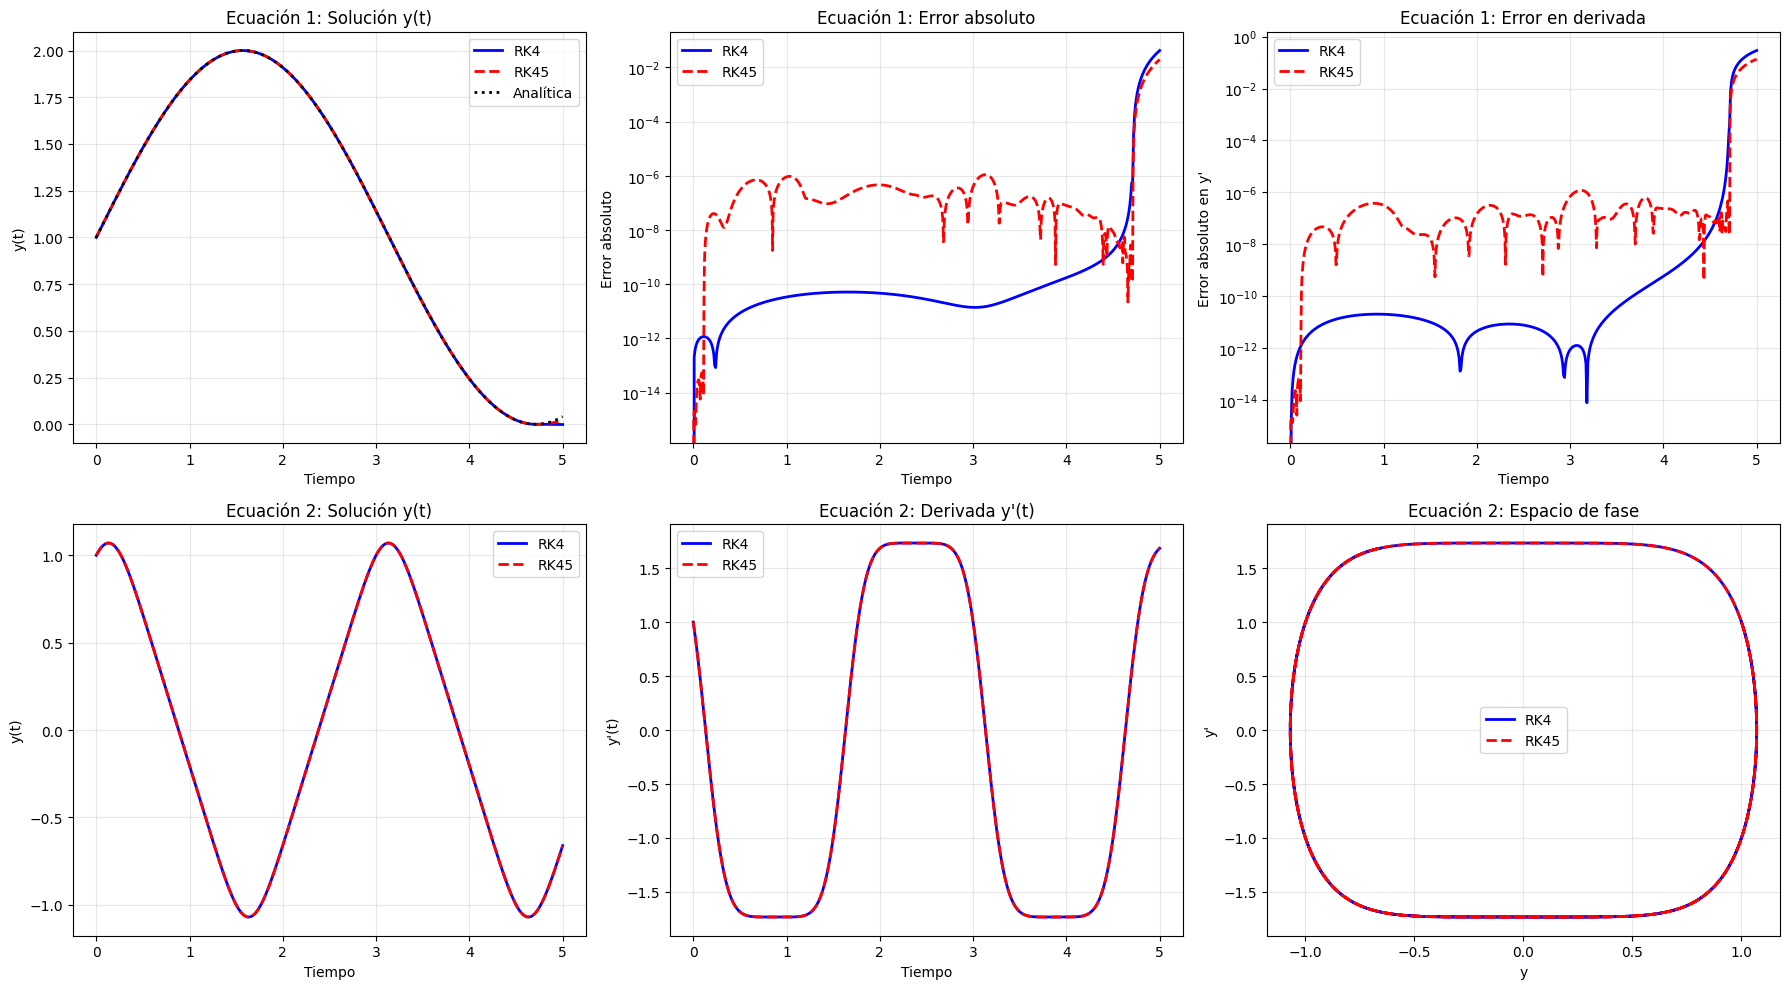

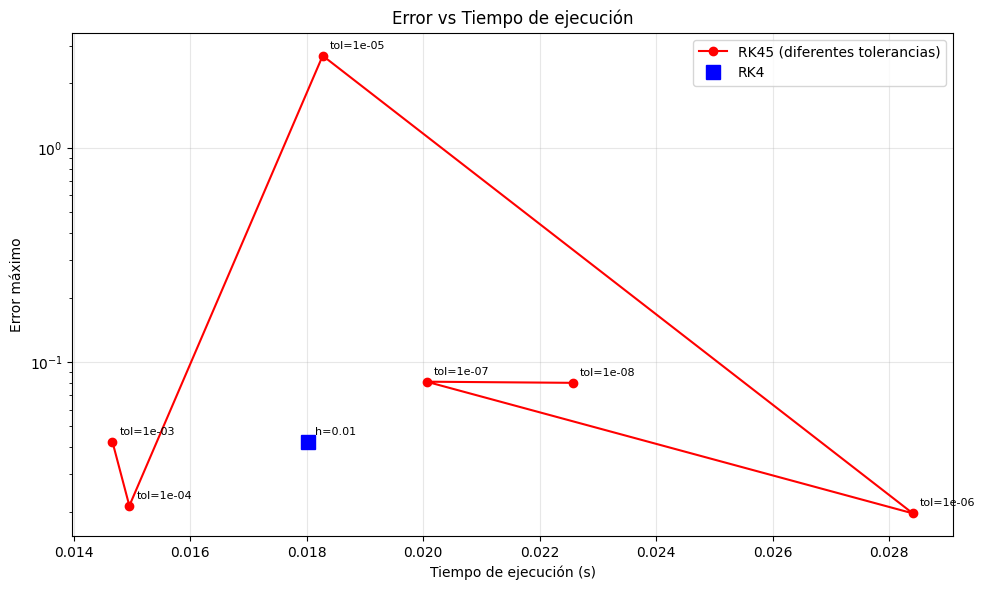

RELACIÓN DE OPERACIONES Y TIEMPO ENTRE MÉTODOS
RK4:  20040 FLOPS, 0.0180 s
RK45: 2400 FLOPS, 0.0130 s
Relación FLOPS: RK45/RK4 = 0.12
Relación tiempo: RK45/RK4 = 0.72


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
import pandas as pd
from tabulate import tabulate

# =============================================================================
# DEFINICIÓN DE LAS ECUACIONES DIFERENCIALES
# =============================================================================

def eq1(t, y):
    """
    Primera ecuación: 2yy'' + y² - y'² = 0
    Convertida a sistema de primer orden:
    y0 = y
    y1 = y'
    """
    # Reorganizamos para obtener y'': y'' = (y'² - y²) / (2y)
    # Para evitar división por cero, usamos un pequeño epsilon cuando y[0] ≈ 0
    epsilon = 1e-12
    y0_adj = y[0] if abs(y[0]) > epsilon else (epsilon if y[0] >= 0 else -epsilon)
    
    dydt = [y[1], (y[1]**2 - y[0]**2) / (2 * y0_adj)]
    return dydt

def eq2(t, y):
    """
    Segunda ecuación: y'' + 6y⁵ = 0
    Convertida a sistema de primer orden:
    y0 = y
    y1 = y'
    """
    dydt = [y[1], -6 * y[0]**5]
    return dydt

# =============================================================================
# SOLUCIÓN ANALÍTICA PARA LA PRIMERA ECUACIÓN
# =============================================================================

def analytical_solution_eq1(t):
    """
    Solución analítica para la primera ecuación: y(t) = 1 + sin(t)
    """
    return 1 + np.sin(t)

def analytical_derivative_eq1(t):
    """
    Derivada de la solución analítica: y'(t) = cos(t)
    """
    return np.cos(t)

# =============================================================================
# IMPLEMENTACIÓN DE RK4
# =============================================================================

def rk4_step(f, t, y, h):
    """
    Un paso del método RK4.
    """
    k1 = h * np.array(f(t, y))
    k2 = h * np.array(f(t + h/2, y + k1/2))
    k3 = h * np.array(f(t + h/2, y + k2/2))
    k4 = h * np.array(f(t + h, y + k3))
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

def solve_rk4(f, t_span, y0, h):
    """
    Resuelve una EDO usando RK4 con paso fijo.
    """
    t0, tf = t_span
    n_steps = int((tf - t0) / h) + 1
    t_values = np.linspace(t0, tf, n_steps)
    y_values = np.zeros((n_steps, len(y0)))
    y_values[0] = y0
    
    start_time = time.time()
    
    for i in range(1, n_steps):
        y_values[i] = rk4_step(f, t_values[i-1], y_values[i-1], h)
    
    comp_time = time.time() - start_time
    # Estimación de FLOPS: 4 evaluaciones de función por paso, cada evaluación tiene ≈ 10 operaciones
    flops = n_steps * 4 * 10
    
    return t_values, y_values, comp_time, flops

# =============================================================================
# IMPLEMENTACIÓN DE RK45 (USANDO SCIPY)
# =============================================================================

def solve_rk45(f, t_span, y0, tol=1e-6):
    """
    Resuelve una EDO usando RK45 adaptativo de scipy.
    """
    start_time = time.time()
    
    # Usamos el método 'DOP853' que es un método de orden 8(5,3) similar a RK45
    sol = solve_ivp(f, t_span, y0, method='DOP853', rtol=tol, atol=tol, dense_output=True)
    
    comp_time = time.time() - start_time
    
    # Evaluar en una malla uniforme para comparación
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    y_eval = sol.sol(t_eval)
    
    # Estimación de FLOPS (aproximada)
    # RK45 requiere aproximadamente 6 evaluaciones de función por paso aceptado
    # y puede tener pasos rechazados. Cada evaluación tiene ≈ 10 operaciones
    n_steps = sol.t.size
    flops = n_steps * 6 * 10
    
    return t_eval, y_eval, comp_time, flops, sol

# =============================================================================
# CÁLCULO DE ERRORES
# =============================================================================

def calculate_errors(t_values, y_values, analytical_func=None, analytical_deriv=None):
    """
    Calcula errores absolutos y relativos.
    """
    if analytical_func is None:
        return np.zeros_like(y_values[0]), np.zeros_like(y_values[0])
    
    y_analytical = analytical_func(t_values)
    y_deriv_analytical = analytical_deriv(t_values) if analytical_deriv else None
    
    abs_error_y = np.abs(y_values[0] - y_analytical)
    rel_error_y = abs_error_y / (np.abs(y_analytical) + 1e-12)
    
    if y_deriv_analytical is not None and y_values.shape[0] > 1:
        abs_error_ydot = np.abs(y_values[1] - y_deriv_analytical)
        rel_error_ydot = abs_error_ydot / (np.abs(y_deriv_analytical) + 1e-12)
    else:
        abs_error_ydot = np.zeros_like(t_values)
        rel_error_ydot = np.zeros_like(t_values)
    
    return abs_error_y, rel_error_y, abs_error_ydot, rel_error_ydot

# =============================================================================
# RESOLVER Y COMPARAR MÉTODOS
# =============================================================================

# Condiciones iniciales
y0 = [1.0, 1.0]  # y(0) = 1, y'(0) = 1
t_span = [0, 5]   # Intervalo de tiempo

# Parámetros
h_rk4 = 0.01      # Paso para RK4
tol_rk45 = 1e-6   # Tolerancia para RK45

# Resolver primera ecuación con ambos métodos
print("Resolviendo primera ecuación: 2yy'' + y² - y'² = 0")
print("Solución analítica conocida: y(t) = 1 + sin(t)")
print()

# RK4 para ecuación 1
t_rk4_eq1, y_rk4_eq1, time_rk4_eq1, flops_rk4_eq1 = solve_rk4(eq1, t_span, y0, h_rk4)
abs_err_rk4_eq1, rel_err_rk4_eq1, abs_err_ydot_rk4_eq1, rel_err_ydot_rk4_eq1 = calculate_errors(
    t_rk4_eq1, y_rk4_eq1.T, analytical_solution_eq1, analytical_derivative_eq1)

# RK45 para ecuación 1
t_rk45_eq1, y_rk45_eq1, time_rk45_eq1, flops_rk45_eq1, sol_rk45_eq1 = solve_rk45(eq1, t_span, y0, tol_rk45)
abs_err_rk45_eq1, rel_err_rk45_eq1, abs_err_ydot_rk45_eq1, rel_err_ydot_rk45_eq1 = calculate_errors(
    t_rk45_eq1, y_rk45_eq1, analytical_solution_eq1, analytical_derivative_eq1)

# Resolver segunda ecuación con ambos métodos
print("Resolviendo segunda ecuación: y'' + 6y⁵ = 0")
print()

# RK4 para ecuación 2
t_rk4_eq2, y_rk4_eq2, time_rk4_eq2, flops_rk4_eq2 = solve_rk4(eq2, t_span, y0, h_rk4)
# No hay solución analítica conocida para la segunda ecuación

# RK45 para ecuación 2
t_rk45_eq2, y_rk45_eq2, time_rk45_eq2, flops_rk45_eq2, sol_rk45_eq2 = solve_rk45(eq2, t_span, y0, tol_rk45)

# =============================================================================
# TABLA DE RESULTADOS
# =============================================================================

# Crear tabla comparativa
table_data = [
    ["Ecuación 1 (RK4)", f"{np.max(abs_err_rk4_eq1):.2e}", f"{np.mean(abs_err_rk4_eq1):.2e}", 
     f"{time_rk4_eq1:.4f}s", f"{flops_rk4_eq1}"],
    ["Ecuación 1 (RK45)", f"{np.max(abs_err_rk45_eq1):.2e}", f"{np.mean(abs_err_rk45_eq1):.2e}", 
     f"{time_rk45_eq1:.4f}s", f"{flops_rk45_eq1}"],
    ["Ecuación 2 (RK4)", "N/A", "N/A", 
     f"{time_rk4_eq2:.4f}s", f"{flops_rk4_eq2}"],
    ["Ecuación 2 (RK45)", "N/A", "N/A", 
     f"{time_rk45_eq2:.4f}s", f"{flops_rk45_eq2}"]
]

headers = ["Método", "Error máximo (y)", "Error promedio (y)", "Tiempo ejecución", "FLOPS estimados"]

print("COMPARACIÓN DE MÉTODOS")
print("=" * 80)
print(tabulate(table_data, headers=headers, tablefmt="grid"))
print()

# =============================================================================
# GRÁFICOS
# =============================================================================

# Configurar estilo de gráficos
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Gráficos para la primera ecuación
# Solución y(t)
axes[0, 0].plot(t_rk4_eq1, y_rk4_eq1[:, 0], 'b-', label='RK4', linewidth=2)
axes[0, 0].plot(t_rk45_eq1, y_rk45_eq1[0], 'r--', label='RK45', linewidth=2)
axes[0, 0].plot(t_rk4_eq1, analytical_solution_eq1(t_rk4_eq1), 'k:', label='Analítica', linewidth=2)
axes[0, 0].set_xlabel('Tiempo')
axes[0, 0].set_ylabel('y(t)')
axes[0, 0].set_title('Ecuación 1: Solución y(t)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Error absoluto
axes[0, 1].semilogy(t_rk4_eq1, abs_err_rk4_eq1, 'b-', label='RK4', linewidth=2)
axes[0, 1].semilogy(t_rk45_eq1, abs_err_rk45_eq1, 'r--', label='RK45', linewidth=2)
axes[0, 1].set_xlabel('Tiempo')
axes[0, 1].set_ylabel('Error absoluto')
axes[0, 1].set_title('Ecuación 1: Error absoluto')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Error en derivada
axes[0, 2].semilogy(t_rk4_eq1, abs_err_ydot_rk4_eq1, 'b-', label='RK4', linewidth=2)
axes[0, 2].semilogy(t_rk45_eq1, abs_err_ydot_rk45_eq1, 'r--', label='RK45', linewidth=2)
axes[0, 2].set_xlabel('Tiempo')
axes[0, 2].set_ylabel('Error absoluto en y\'')
axes[0, 2].set_title('Ecuación 1: Error en derivada')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Gráficos para la segunda ecuación
# Solución y(t)
axes[1, 0].plot(t_rk4_eq2, y_rk4_eq2[:, 0], 'b-', label='RK4', linewidth=2)
axes[1, 0].plot(t_rk45_eq2, y_rk45_eq2[0], 'r--', label='RK45', linewidth=2)
axes[1, 0].set_xlabel('Tiempo')
axes[1, 0].set_ylabel('y(t)')
axes[1, 0].set_title('Ecuación 2: Solución y(t)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Derivada y'(t)
axes[1, 1].plot(t_rk4_eq2, y_rk4_eq2[:, 1], 'b-', label='RK4', linewidth=2)
axes[1, 1].plot(t_rk45_eq2, y_rk45_eq2[1], 'r--', label='RK45', linewidth=2)
axes[1, 1].set_xlabel('Tiempo')
axes[1, 1].set_ylabel('y\'(t)')
axes[1, 1].set_title('Ecuación 2: Derivada y\'(t)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Espacio de fase (y vs y')
axes[1, 2].plot(y_rk4_eq2[:, 0], y_rk4_eq2[:, 1], 'b-', label='RK4', linewidth=2)
axes[1, 2].plot(y_rk45_eq2[0], y_rk45_eq2[1], 'r--', label='RK45', linewidth=2)
axes[1, 2].set_xlabel('y')
axes[1, 2].set_ylabel('y\'')
axes[1, 2].set_title('Ecuación 2: Espacio de fase')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE PRECISIÓN VS TIEMPO DE EJECUCIÓN
# =============================================================================

# Probar diferentes tolerancias para RK45
tolerances = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
errors_vs_time = []

for tol in tolerances:
    # Resolver con RK45
    t_rk45, y_rk45, time_rk45, flops_rk45, _ = solve_rk45(eq1, t_span, y0, tol)
    abs_err, rel_err, _, _ = calculate_errors(t_rk45, y_rk45, analytical_solution_eq1, analytical_derivative_eq1)
    max_error = np.max(abs_err)
    errors_vs_time.append((tol, max_error, time_rk45, flops_rk45))

# Comparar con RK4
errors_vs_time.append((h_rk4, np.max(abs_err_rk4_eq1), time_rk4_eq1, flops_rk4_eq1))

# Gráfico de error vs tiempo de ejecución
fig, ax1 = plt.subplots(figsize=(10, 6))

# Extraer datos
tols = [item[0] for item in errors_vs_time]
errors = [item[1] for item in errors_vs_time]
times = [item[2] for item in errors_vs_time]
flops = [item[3] for item in errors_vs_time]

# Graficar error vs tiempo
ax1.semilogy(times[:-1], errors[:-1], 'ro-', label='RK45 (diferentes tolerancias)')
ax1.semilogy(times[-1], errors[-1], 'bs', markersize=10, label='RK4')
ax1.set_xlabel('Tiempo de ejecución (s)')
ax1.set_ylabel('Error máximo')
ax1.set_title('Error vs Tiempo de ejecución')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Añadir anotaciones para las tolerancias
for i, (tol, error, time_val, flops_val) in enumerate(errors_vs_time[:-1]):
    ax1.annotate(f'tol={tol:.0e}', (time_val, error), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)

ax1.annotate(f'h={h_rk4}', (times[-1], errors[-1]), xytext=(5, 5), 
            textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Mostrar relación FLOPS entre métodos
print("RELACIÓN DE OPERACIONES Y TIEMPO ENTRE MÉTODOS")
print("=" * 50)
print(f"RK4:  {flops_rk4_eq1} FLOPS, {time_rk4_eq1:.4f} s")
print(f"RK45: {flops_rk45_eq1} FLOPS, {time_rk45_eq1:.4f} s")
print(f"Relación FLOPS: RK45/RK4 = {flops_rk45_eq1/flops_rk4_eq1:.2f}")
print(f"Relación tiempo: RK45/RK4 = {time_rk45_eq1/time_rk4_eq1:.2f}")